<a href="https://colab.research.google.com/github/anand-bidwalkar/SIT796-Reinforcement-Learning/blob/master/Task-1.1C%5CSIT796_Task1_1C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SIT-796 Reinforcement Learning Task-1.1 C Custom Environment

Github link https://github.com/anand-bidwalkar/SIT796-Reinforcement-Learning/blob/master/Task-1.1C/SIT796_Task1_1C.ipynb

Install dependencies for the environment

In [1]:
# install required dependencies
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet
!pip install stable-baselines
!pip install tensorflow==1.14.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 1s (1,289 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:

Import the required libraries

In [2]:
import random, json, gym
from gym import spaces
import pandas as pd
import numpy as np
import datetime as dt
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Define the constants for the policy execution

In [3]:
MAX_ACCOUNT_BALANCE = 1000000
MAX_NUM_SHARES = 10000
MAX_SHARE_PRICE = 1000
MAX_STEPS = 20000
INITIAL_ACCOUNT_BALANCE = 10000

Define the custom gym environment for the stock trading

In [4]:
class CustomStockTradingEnvironment(gym.Env):

    def __init__(self, df):
      self.df = df

      # Discrete action space to hold values for Buy, Sell, Hold
      self.action_space = spaces.Box(
          low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

      # Discrete state space to hold values for Open, Low, High, Close, Volume
      self.observation_space = spaces.Box(
          low=0, high=1, shape=(6, 5), dtype=np.float16)

    def _get_next_observation(self):
      # Get the stock data points for the last 5 days and scale to between 0-1
      frame = np.array([
          self.df.loc[self.current_step: self.current_step +
                      4, 'Open'].values / MAX_SHARE_PRICE,
          self.df.loc[self.current_step: self.current_step +
                      4, 'High'].values / MAX_SHARE_PRICE,
          self.df.loc[self.current_step: self.current_step +
                      4, 'Low'].values / MAX_SHARE_PRICE,
          self.df.loc[self.current_step: self.current_step +
                      4, 'Close'].values / MAX_SHARE_PRICE,
          self.df.loc[self.current_step: self.current_step +
                      4, 'Volume'].values / MAX_NUM_SHARES,
      ])

      # Append additional data and scale each value to between 0-1
      obs = np.append(frame, [[
          self.balance / MAX_ACCOUNT_BALANCE,
          self.shares_held / MAX_NUM_SHARES,
          self.total_shares_sold / MAX_NUM_SHARES,
          self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
          1
      ]], axis=0)

      return obs

    def _action(self, action):
      # Set the current price to a random price within the time step
      current_price = random.uniform(
          self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

      action_type = action[0]
      amount = action[1]

      if action_type < 1:
          # Buy amount % of balance in shares
          total_possible = int(self.balance / current_price)
          shares_bought = int(total_possible * amount)
          additional_cost = shares_bought * current_price
          self.balance -= additional_cost
          self.shares_held += shares_bought

      elif action_type < 2:
          # Sell amount % of shares held
          shares_sold = int(self.shares_held * amount)
          self.balance += shares_sold * current_price
          self.shares_held -= shares_sold
          self.total_shares_sold += shares_sold
          self.total_sales_value += shares_sold * current_price

      self.net_worth = self.balance + self.shares_held * current_price

    def reward(self):
      delayed_reward = (self.current_step / MAX_STEPS)
      current_reward = self.balance * delayed_reward
      print('Reward for current step:' + str(current_reward))
      return current_reward

    def step(self, action):
      # Execute one time step within the environment
      self._action(action)
      self.current_step += 1

      if self.current_step > len(self.df.loc[:, 'Open'].values) - 5:
          self.current_step = 0

      reward = self.reward()
      done = self.net_worth <= 0
      obs = self._get_next_observation()

      return obs, reward, done, {}

    def reset(self):
      # reset the value of constants in state space to initial values
      self.balance = INITIAL_ACCOUNT_BALANCE
      self.net_worth = INITIAL_ACCOUNT_BALANCE
      self.shares_held = 0
      self.total_shares_sold = 0
      self.total_sales_value = 0

      # set the current step to random observation in the dataset
      self.current_step = random.randint(0, len(self.df.loc[:, 'Open'].values) - 6)

      return self._get_next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        print('Current Step: ', self.current_step)
        print('Account Balance: ', self.balance)
        print('Number of shares held: {0} Total sold: {1}'.format(self.shares_held, self.total_shares_sold))
        print('Profit accumulated: ', self.net_worth - INITIAL_ACCOUNT_BALANCE)

In [6]:
! git clone https://github.com/anand-bidwalkar/SIT796-Reinforcement-Learning.git

Cloning into 'SIT796-Reinforcement-Learning'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


Define Environment

In [7]:
# Load stock trading data for the agent
df = pd.read_csv('/content/SIT796-Reinforcement-Learning/Task-1.1C/Trading-Data.csv')
df = df.sort_values('Date')

# The algorithms require a vectorized environment to run
env = DummyVecEnv([lambda: CustomStockTradingEnvironment(df)])

# MlpPolicy - Policy object that implements actor critic, using a MLP (2 layers of 64)
model = PPO2(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=20000)
cummulative_reward = 0
cummulative_reward_list = []

obs = env.reset()
for i in range(2000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    cummulative_reward += rewards[0]
    cummulative_reward_list.append(cummulative_reward)
    env.render()





Instructions for updating:
Use keras.layers.flatten instead.



/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Streaming output truncated to the last 5000 lines.
Reward for current step:1662.482467221236
Current Step:  2728
Account Balance:  12188.287882853638
Number of shares held: 17 Total sold: 2178
Profit accumulated:  4070.993790835335
Reward for current step:1663.0918816153787
Current Step:  2729
Account Balance:  12188.287882853638
Number of shares held: 17 Total sold: 2178
Profit accumulated:  4002.338886295227
Reward for current step:1663.7012960095217
Current Step:  2730
Account Balance:  12188.287882853638
Number of shares held: 17 Total sold: 2178
Profit accumulated:  3887.051597357058
Reward for current step:1744.9633196920854
Current Step:  2731
Account Balance:  12778.933135789714
Number of shares held: 11 Total sold: 2184
Profit accumulated:  3861.7827661725205
Reward for current step:1745.6022663488748
Current Step:  2732
Account Balance:  12778.933135789714
Number of shares held: 11 Total sold: 2184
Profit accumulated:  3843.9319089600776
Reward for current step:1888.751745864

The plot to show relation between cummulative reward and number of steps

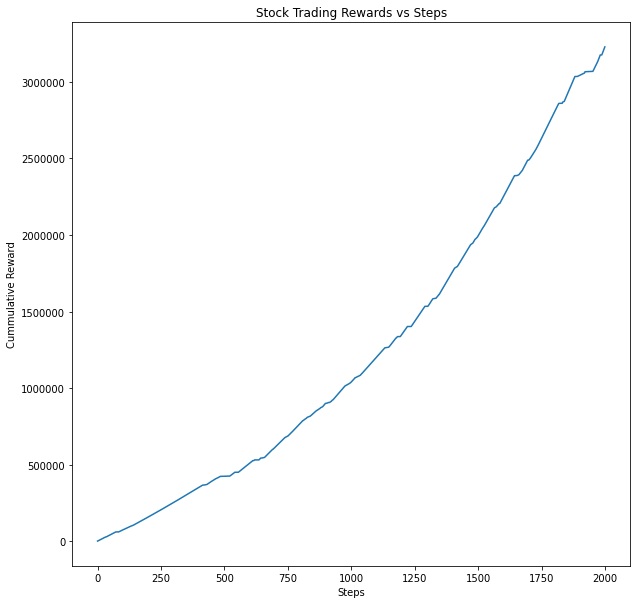

In [11]:
plt.figure(figsize=(10, 10))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Cummulative Reward')
plt.xlabel('Steps')
plt.title('Stock Trading Rewards vs Steps')
plt.plot(cummulative_reward_list)